In [19]:
%load_ext autoreload
%autoreload 2
%autosave 30

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

import matplotlib.pyplot as plt
from plotutils import plot_images_as_grid

from imageprosessing import hist_match_images, enhance_motion_contrast, normalize_data
from sharedvariables import get_video_sessions
from video_session import VideoSession
from imageprosessing import SessionPreprocessor
from classificationutils import SessionClassifier
from patchextraction import SessionPatchExtractor
from patchextraction import SessionPatchExtractor as PE
from cnnlearning import CNN

from learningutils import ImageDataset
from classificationutils import create_probability_map
from plotutils import *
from cnnlearning import TrainingTracker, train
import os
import collections
import pathlib

import scipy
import skimage
from skimage.morphology import binary_dilation as bd
import re
import numpy as np
import pandas as pd
import torch
import cv2
import copy

from tqdm.contrib import tzip

from patchextraction import extract_patches
from patchextraction import NegativeExtractionMode
from imageprosessing import ImageRegistrator
from collections import OrderedDict

# change this
result_folder_name = 'uid6-sc-npp32-tp5-ps23-mt0-pr0-uv1'

## ## ## ## ##
patch_size_str = result_folder_name.split('-')[4]
assert 'ps' in patch_size_str
patch_size = int(re.findall(r'\d+', patch_size_str)[0])

print('Patch size', patch_size)

classifier_params = collections.OrderedDict(        
    patch_size=patch_size,
    
    mixed_channels=False,
    drop_confocal=False,

    n_negatives_per_positive=32,
    negative_extraction_mode=NegativeExtractionMode.CIRCLE,                             
    use_vessel_mask=True
)


report_images_folder = os.path.join(
    '..', '..', 'thesis-report', 'images', result_folder_name,
)
pathlib.Path(report_images_folder).mkdir(exist_ok=True, parents=False)

result_evaluation_folder = f'tmp-res/{result_folder_name}/evaluation'
pathlib.Path(report_images_folder).mkdir(exist_ok=True, parents=False)

print()
results = TrainingTracker.from_file(os.path.join('tmp-res', result_folder_name, 'results.pkl'))
print('Training results loaded')

recorded_models_props = results.recorded_models['best_valid_balanced_accuracy']
model =  recorded_models_props['model'].eval()

print()
print('Model validation performance\n',  recorded_models_props['valid_classification_results'])
print()

video_sessions = get_video_sessions(marked=True, registered=False, validation=True)
print('loaded validation Video sessions:', len(video_sessions))
[vs.basename for vs in video_sessions]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 30 seconds
Patch size 23

Training results loaded

Model validation performance
    Balanced Accuracy  Accuracy  Sensitivity  Specificity
0           0.813884  0.801461     0.827957     0.799811

loaded validation Video sessions: 3


['Subject10_Session109_OD_(-1,0)_1x1_416_OA790nm1_extract_reg_cropped',
 'Subject10_Session111_OS_(1.2,0)_1x1_429_OA790nm1_extract_reg_cropped',
 'Subject3_Session216_OD_(0,0)_1x1_980_OA790nm1_extract_reg_cropped']

### Load validation videos and make sure vessel masks are ok

In [20]:
validation_video_sessions = get_video_sessions(marked=True, validation=True)

[vs.load_vessel_masks(False) for vs in validation_video_sessions]
[vs.basename for vs in validation_video_sessions]

['Subject10_Session109_OD_(-1,0)_1x1_416_OA790nm1_extract_reg_cropped',
 'Subject10_Session111_OS_(1.2,0)_1x1_429_OA790nm1_extract_reg_cropped',
 'Subject3_Session216_OD_(0,0)_1x1_980_OA790nm1_extract_reg_cropped']

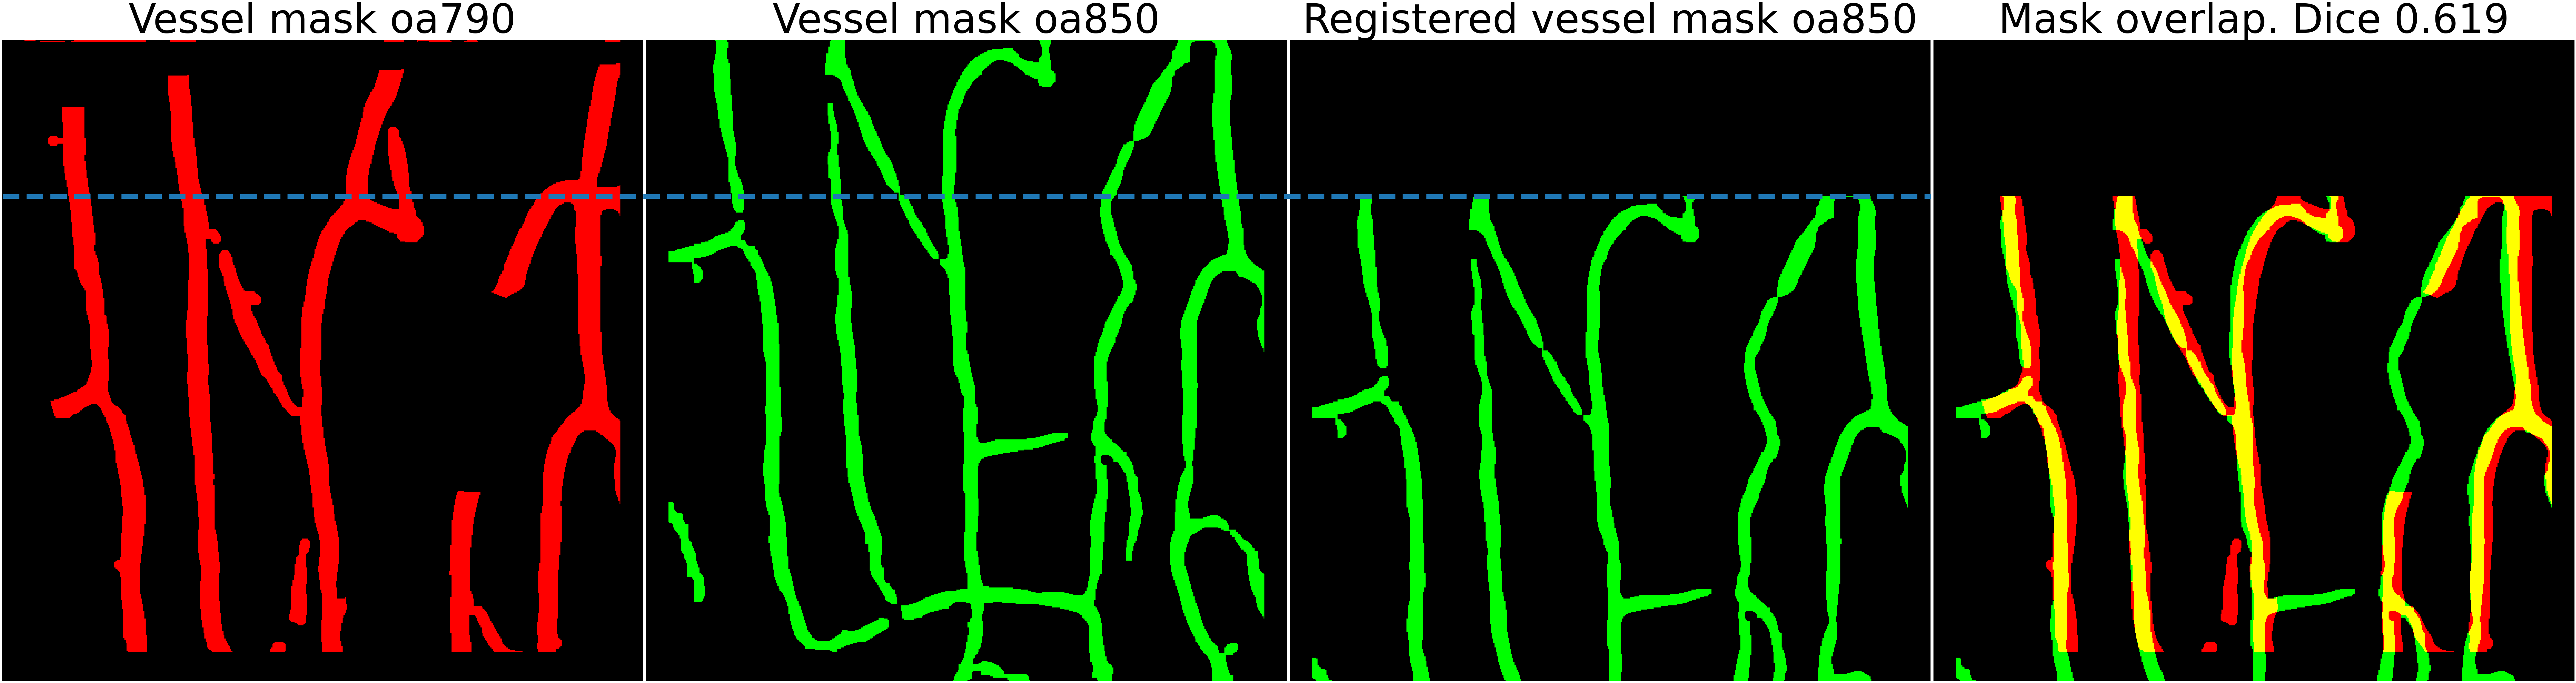

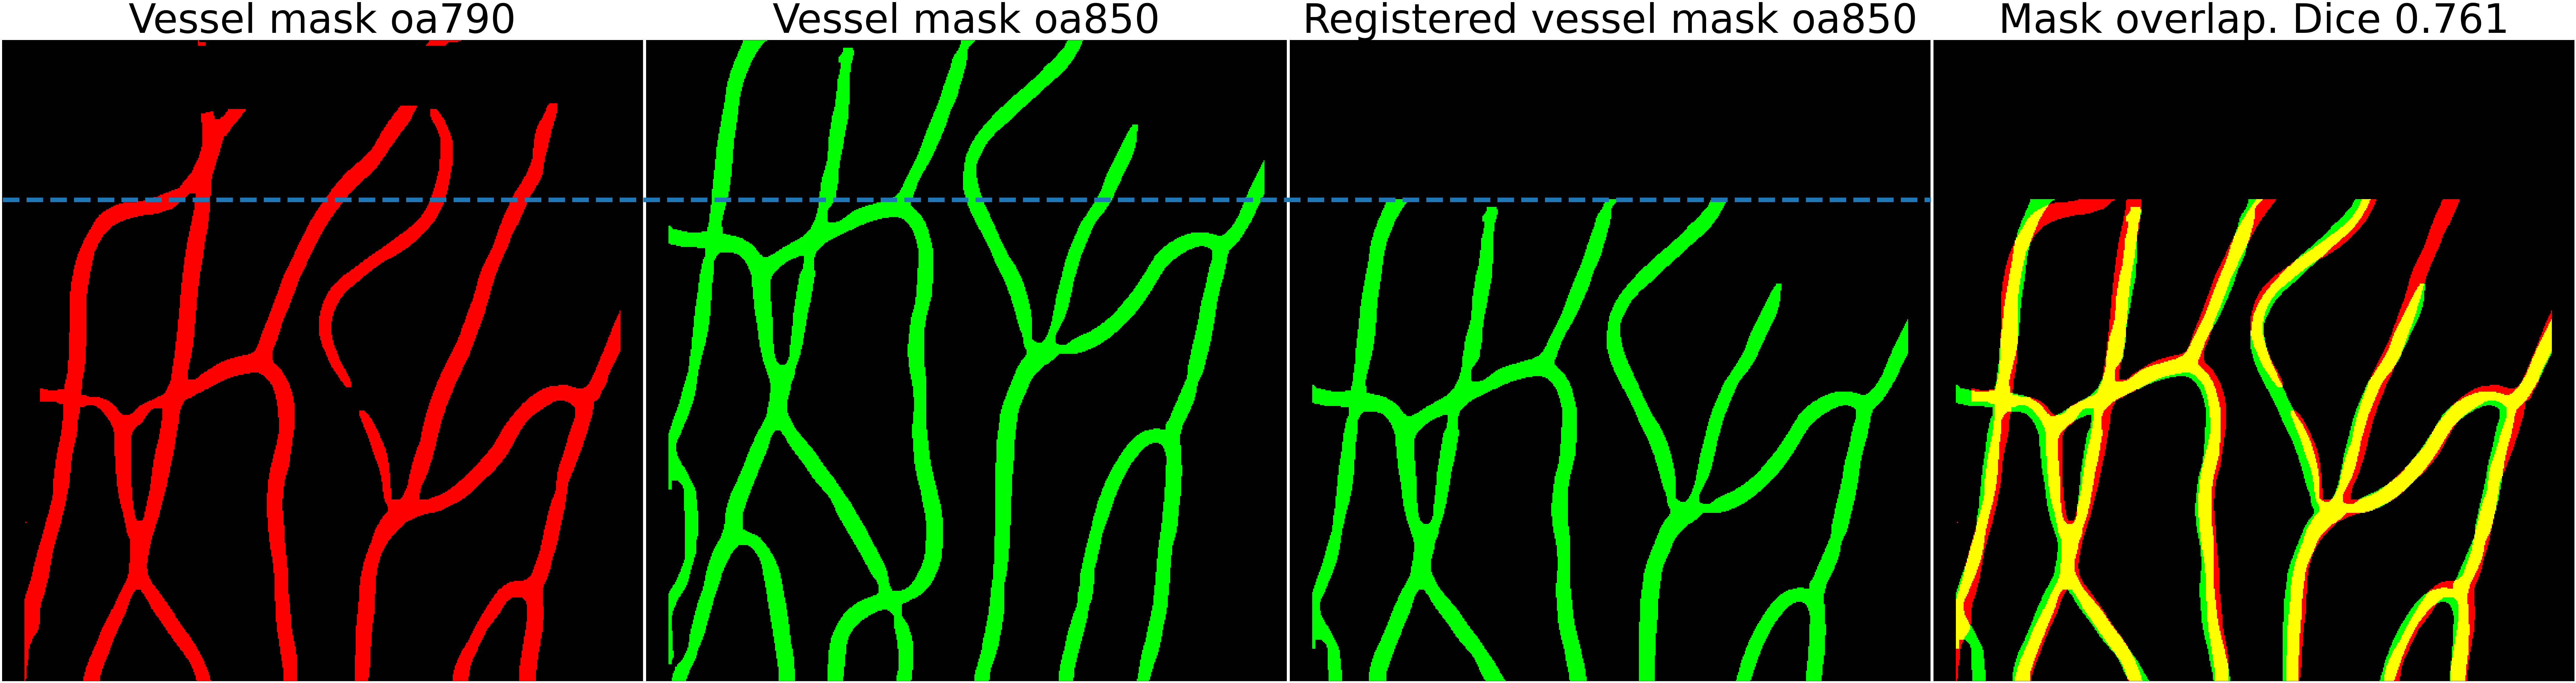

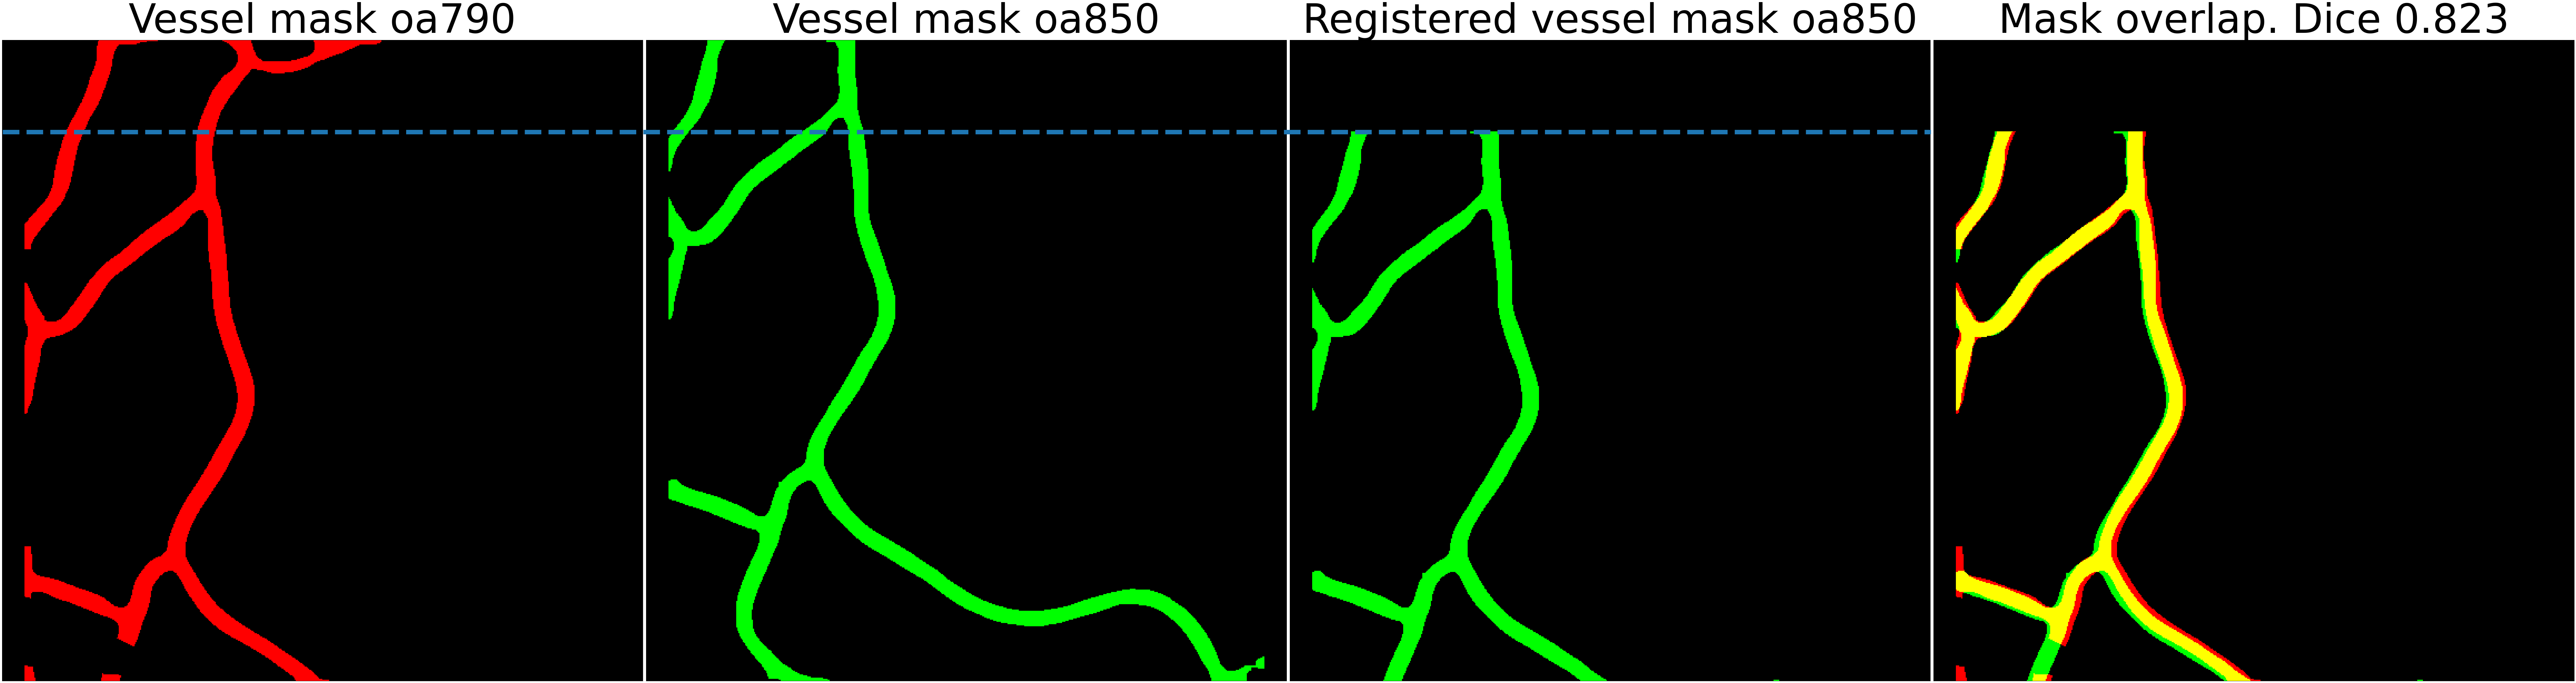

In [21]:
for vs in validation_video_sessions:
    vs.visualize_registration()

# Performance on validation data

### Performance on patch classification

In [13]:
valid_recorded_model_props = results.recorded_models['best_valid_balanced_accuracy']
model = valid_recorded_model_props['model'].eval()

classification_results = valid_recorded_model_props['valid_classification_results']

sensitivities = []
specificities = []
balanced_accuracies  = []
accuracies = []

print('General validation performance\n', classification_results)
for vs in validation_video_sessions:
    vs_c = SessionClassifier(vs, model, **classifier_params)
    classification_results = vs_c.classify_cells()
    
    sensitivity = classification_results.positive_accuracy
    specificity = classification_results.negative_accuracy
    balanced_accuracy = classification_results.balanced_accuracy
    accuracy = classification_results.accuracy
    
    sensitivities.append(sensitivity)
    specificities.append(specificity)
    balanced_accuracies.append(balanced_accuracy)
    accuracies.append(accuracy)
    
    print(vs.basename)
    print(f'Sensitivity: {sensitivity:.3f}', 
          f'Specificity: {specificity:.3f}',
          f'Balanced acc: {balanced_accuracy:.3f}',
          f'accuracy: {accuracy:.3f}', sep='\n')
    print('-----------')

General validation performance
    Balanced Accuracy  Accuracy  Sensitivity  Specificity
0           0.813884  0.801461     0.827957     0.799811
Subject10_Session109_OD_(-1,0)_1x1_416_OA790nm1_extract_reg_cropped
Sensitivity: 0.840
Specificity: 0.761
Balanced acc: 0.801
accuracy: 0.767
-----------
Subject10_Session111_OS_(1.2,0)_1x1_429_OA790nm1_extract_reg_cropped
Sensitivity: 0.746
Specificity: 0.730
Balanced acc: 0.738
accuracy: 0.731
-----------
Subject3_Session216_OD_(0,0)_1x1_980_OA790nm1_extract_reg_cropped
Sensitivity: 0.873
Specificity: 0.816
Balanced acc: 0.845
accuracy: 0.819
-----------


In [14]:
test_sensitivity = np.mean(sensitivities)
test_specificity = np.mean(specificities)
test_balanced_accuracy = np.mean(balanced_accuracies)
test_accuracy = np.mean(accuracies)

performance_data = {
    'Balanced accuracy': test_balanced_accuracy,
    'Accuracy': test_accuracy,
    'Sensitivity': test_sensitivity,
    'Specificity': test_specificity
}

df = pd.DataFrame(performance_data, columns=list(performance_data.keys()), index=[0])
print(df.to_string(index=False))


 Balanced accuracy  Accuracy  Sensitivity  Specificity
          0.794507  0.772487     0.819874      0.76914


### Position estimation

In [18]:
uid_to_s = {416: 1.833333333333334, 429: 1.3000000000000003, 980: 1.5777777777777784}
uid_to_h = {416: 0.3833333333333333, 429: 0.30000000000000004, 980: 0.3333333333333333}
uid_to_t = {416: 0.6166666666666668, 429: 0.5750000000000001, 980: 0.588888888888889}

session_classifiers = []
for vs in validation_video_sessions:
    print('-----------')
    print(vs.basename)
    
    vsc = SessionClassifier(vs, model, **classifier_params)
    session_classifiers.append(vsc)
    
    print('Estimating positions...')
    for frame_idx in vs.cell_positions:
        vsc.estimate_locations(
            frame_idx,
            sigma=uid_to_s[vs.uid],
            extended_maxima_h=uid_to_h[vs.uid],
            region_max_threshold=uid_to_t[vs.uid],
            grid_search=False
        )

    vsc.save(os.path.join(result_evaluation_folder, f'uid{vs.uid}_classification_results.pkl'), v=True)

-----------
Subject10_Session109_OD_(-1,0)_1x1_416_OA790nm1_extract_reg_cropped
Estimating positions...
Saved tmp-res/uid6-sc-npp32-tp5-ps23-mt0-pr0-uv1/evaluation\uid416_classification_results.pkl
-----------
Subject10_Session111_OS_(1.2,0)_1x1_429_OA790nm1_extract_reg_cropped
Estimating positions...
Saved tmp-res/uid6-sc-npp32-tp5-ps23-mt0-pr0-uv1/evaluation\uid429_classification_results.pkl
-----------
Subject3_Session216_OD_(0,0)_1x1_980_OA790nm1_extract_reg_cropped
Estimating positions...
Saved tmp-res/uid6-sc-npp32-tp5-ps23-mt0-pr0-uv1/evaluation\uid980_classification_results.pkl


In [23]:
for vsc in session_classifiers:
    print(vsc.session.uid)
    sigmas = [evaluation.sigma for evaluation in vsc.result_evaluations.values()]
    hs = [evaluation.extended_maxima_h for evaluation in vsc.result_evaluations.values()]
    ts = [evaluation.region_max_threshold for evaluation in vsc.result_evaluations.values()]
    
    dices = [evaluation.dice for evaluation in vsc.result_evaluations.values()]
    false_discovery_rates = [evaluation.false_discovery_rate for evaluation in vsc.result_evaluations.values()]
    true_positive_rates = [evaluation.true_positive_rate for evaluation in vsc.result_evaluations.values()]
    

    print(f'Dice: {np.mean(dices):.3f}', 
          f'False discovery rate: {np.mean(false_discovery_rates):.3f}',
          f'True positive rate: {np.mean(true_positive_rates):.3f}', sep='\n')
    print('-----------')

416
Dice: 0.729
False discovery rate: 0.353
True positive rate: 0.843
-----------
429
Dice: 0.770
False discovery rate: 0.296
True positive rate: 0.853
-----------
980
Dice: 0.838
False discovery rate: 0.164
True positive rate: 0.844
-----------


In [7]:
all_dices = []
all_false_discovery_rates = []
all_true_positive_rates = []

all_sigmas = []
all_hs = []
all_ts = []

uid_to_sigmas = {}
uid_to_hs = {}
uid_to_ts = {}

uid_to_s = {}
uid_to_h = {}
uid_to_t = {}

for vsc in session_classifiers:
    sigmas = [evaluation.sigma for evaluation in vsc.result_evaluations.values()]
    hs = [evaluation.extended_maxima_h for evaluation in vsc.result_evaluations.values()]
    ts = [evaluation.region_max_threshold for evaluation in vsc.result_evaluations.values()]
    
    dices = [evaluation.dice for evaluation in vsc.result_evaluations.values()]
    false_discovery_rates = [evaluation.false_discovery_rate for evaluation in vsc.result_evaluations.values()]
    true_positive_rates = [evaluation.true_positive_rate for evaluation in vsc.result_evaluations.values()]
    
    print(vsc.session.uid)
    uid_to_sigmas[vsc.session.uid] =  sigmas
    uid_to_hs[vsc.session.uid] = hs
    uid_to_ts[vsc.session.uid] = ts
    
    uid_to_s[vsc.session.uid] = np.mean(sigmas)
    uid_to_h[vsc.session.uid] = np.mean(hs)
    uid_to_t[vsc.session.uid] = np.mean(ts)
    
    all_sigmas.extend(sigmas)
    all_hs.extend(hs)
    all_ts.extend(ts)
    
    all_dices.extend(dices)
    all_false_discovery_rates.extend(false_discovery_rates)
    all_true_positive_rates.extend(true_positive_rates)

416
429
980


In [8]:
model

CNN(
  (convolutional): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): AvgPool2d(kernel_size=3, stride=2, padding=1)
    (7): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): AvgPool2d(kernel_size=3, stride=2, padding=1)
  )
  (dense): Sequential(
    (0): Linear(in_features=576, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): 

In [9]:
import collections
data = collections.OrderedDict(
    dice=np.mean(all_dices),
    true_positive_rate=np.mean(all_true_positive_rates), 
    false_discovery_rate=np.mean(all_false_discovery_rates)
)
print(pd.DataFrame(data, columns=list(data.keys()), index=[0]).to_string(index=False))

     dice  true_positive_rate  false_discovery_rate
 0.789026             0.84572              0.251744


### Load session classifiers

In [10]:
loaded_session_classifiers = []

# Load session_classifiers
for vs in validation_video_sessions:
    vsc = SessionClassifier.from_file(
        os.path.join(result_evaluation_folder, f'uid{vs.uid}_classification_results.pkl'), v=False)
    loaded_session_classifiers.append(vsc)

In [11]:
all_dices = []
all_false_discovery_rates = []
all_true_positive_rates = []
all_true_positive_dists = []

for vsc in loaded_session_classifiers:
    sigmas = [evaluation.sigma for evaluation in vsc.result_evaluations.values()]
    hs = [evaluation.extended_maxima_h for evaluation in vsc.result_evaluations.values()]
    ts = [evaluation.region_max_threshold for evaluation in vsc.result_evaluations.values()]
    
    dices = [evaluation.dice for evaluation in vsc.result_evaluations.values()]
    false_discovery_rates = [evaluation.false_discovery_rate for evaluation in vsc.result_evaluations.values()]
    true_positive_rates = [evaluation.true_positive_rate for evaluation in vsc.result_evaluations.values()]
    true_positive_dists = [evaluation.true_positive_dists.mean() for evaluation in vsc.result_evaluations.values()]
    
    all_dices.extend(dices)
    all_false_discovery_rates.extend(false_discovery_rates)
    all_true_positive_rates.extend(true_positive_rates)
    all_true_positive_dists.extend(true_positive_dists)

In [12]:
test_sensitivity = np.mean(sensitivities)
test_specificity = np.mean(specificities)
test_balanced_accuracy = np.mean(balanced_accuracies)
test_accuracy = np.mean(accuracies)

performance_data = {
    'Balanced accuracy': test_balanced_accuracy,
    'Accuracy': test_accuracy,
    'Sensitivity': test_sensitivity,
    'Specificity': test_specificity
}

df = pd.DataFrame(performance_data, columns=list(performance_data.keys()), index=[0])
print(df.to_string(index=False))

 Balanced accuracy  Accuracy  Sensitivity  Specificity
          0.796865  0.776612     0.820105     0.773625


In [13]:
import collections
data = collections.OrderedDict(
    dice=np.mean(all_dices),
    true_positive_rate=np.mean(all_true_positive_rates), 
    false_discovery_rate=np.mean(all_false_discovery_rates),
    mean_distance=np.mean(all_true_positive_dists)
)
print(pd.DataFrame(data, columns=list(data.keys()), index=[0]).to_string(index=False))

     dice  true_positive_rate  false_discovery_rate  mean_distance
 0.789026             0.84572              0.251744       4.423485


In [14]:
def probability_map_cmap(probability_map, sigma):
    from PIL import Image
    from skimage.filters import gaussian
    probability_map = probability_map
    probability_map = gaussian(probability_map, sigma)
    probability_map = np.uint8(probability_map * 255)
    probability_map = cv2.applyColorMap(probability_map, cv2.COLORMAP_JET)
    probability_map = cv2.cvtColor(probability_map, cv2.COLOR_BGR2RGB)
    probability_map = Image.fromarray(probability_map)
    return probability_map

### Worst probability map

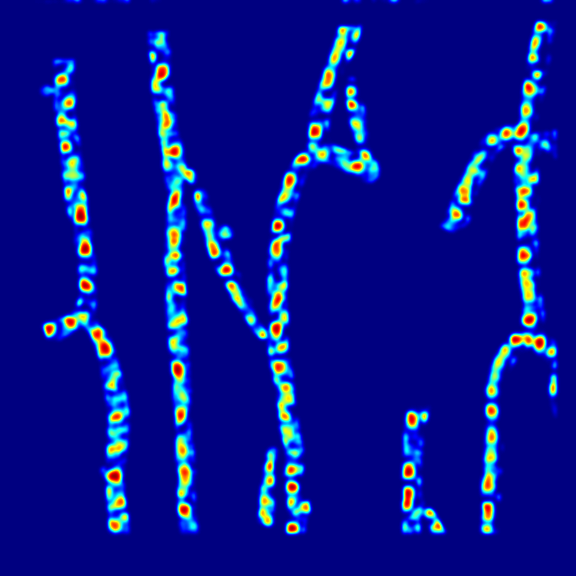

In [15]:
vsc_idx = 0
worse_dice_idx = np.argmin([vsc.dice for vsc in loaded_session_classifiers[vsc_idx].result_evaluations.values()])
worst_prob_map_frame_idx = list(loaded_session_classifiers[vsc_idx].result_evaluations.keys())[worse_dice_idx]

prob_map = probability_map_cmap(loaded_session_classifiers[vsc_idx].probability_maps[worst_prob_map_frame_idx], 
                                loaded_session_classifiers[vsc_idx].result_evaluations[worst_prob_map_frame_idx].sigma)
prob_map

### Best probability map

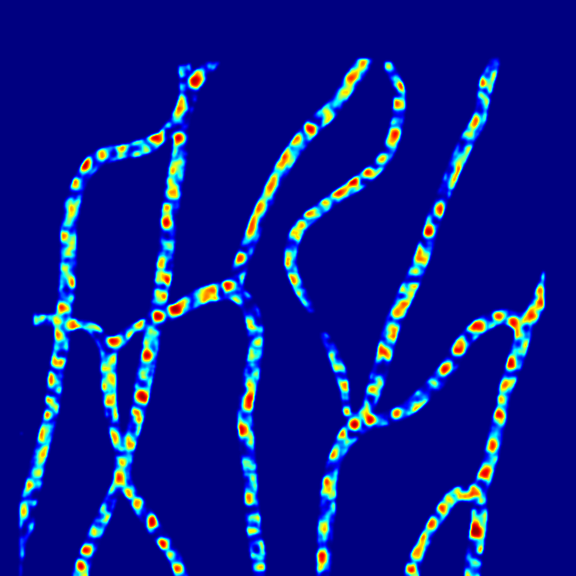

In [16]:
vsc_idx = 1
best_dice_idx = np.argmax([vsc.dice for vsc in loaded_session_classifiers[vsc_idx].result_evaluations.values()])
best_prob_map_frame_idx =list(loaded_session_classifiers[vsc_idx].result_evaluations.keys())[best_dice_idx]
prob_map = probability_map_cmap(loaded_session_classifiers[vsc_idx].probability_maps[best_prob_map_frame_idx], 
                     loaded_session_classifiers[vsc_idx].result_evaluations[best_prob_map_frame_idx].sigma)
prob_map.save(f'{os.path.splitext((loaded_session_classifiers[vsc_idx].session.basename))[0]}_best.png')
prob_map

Saved  Subject10_Session111_OS_(1_result_evaluation.png


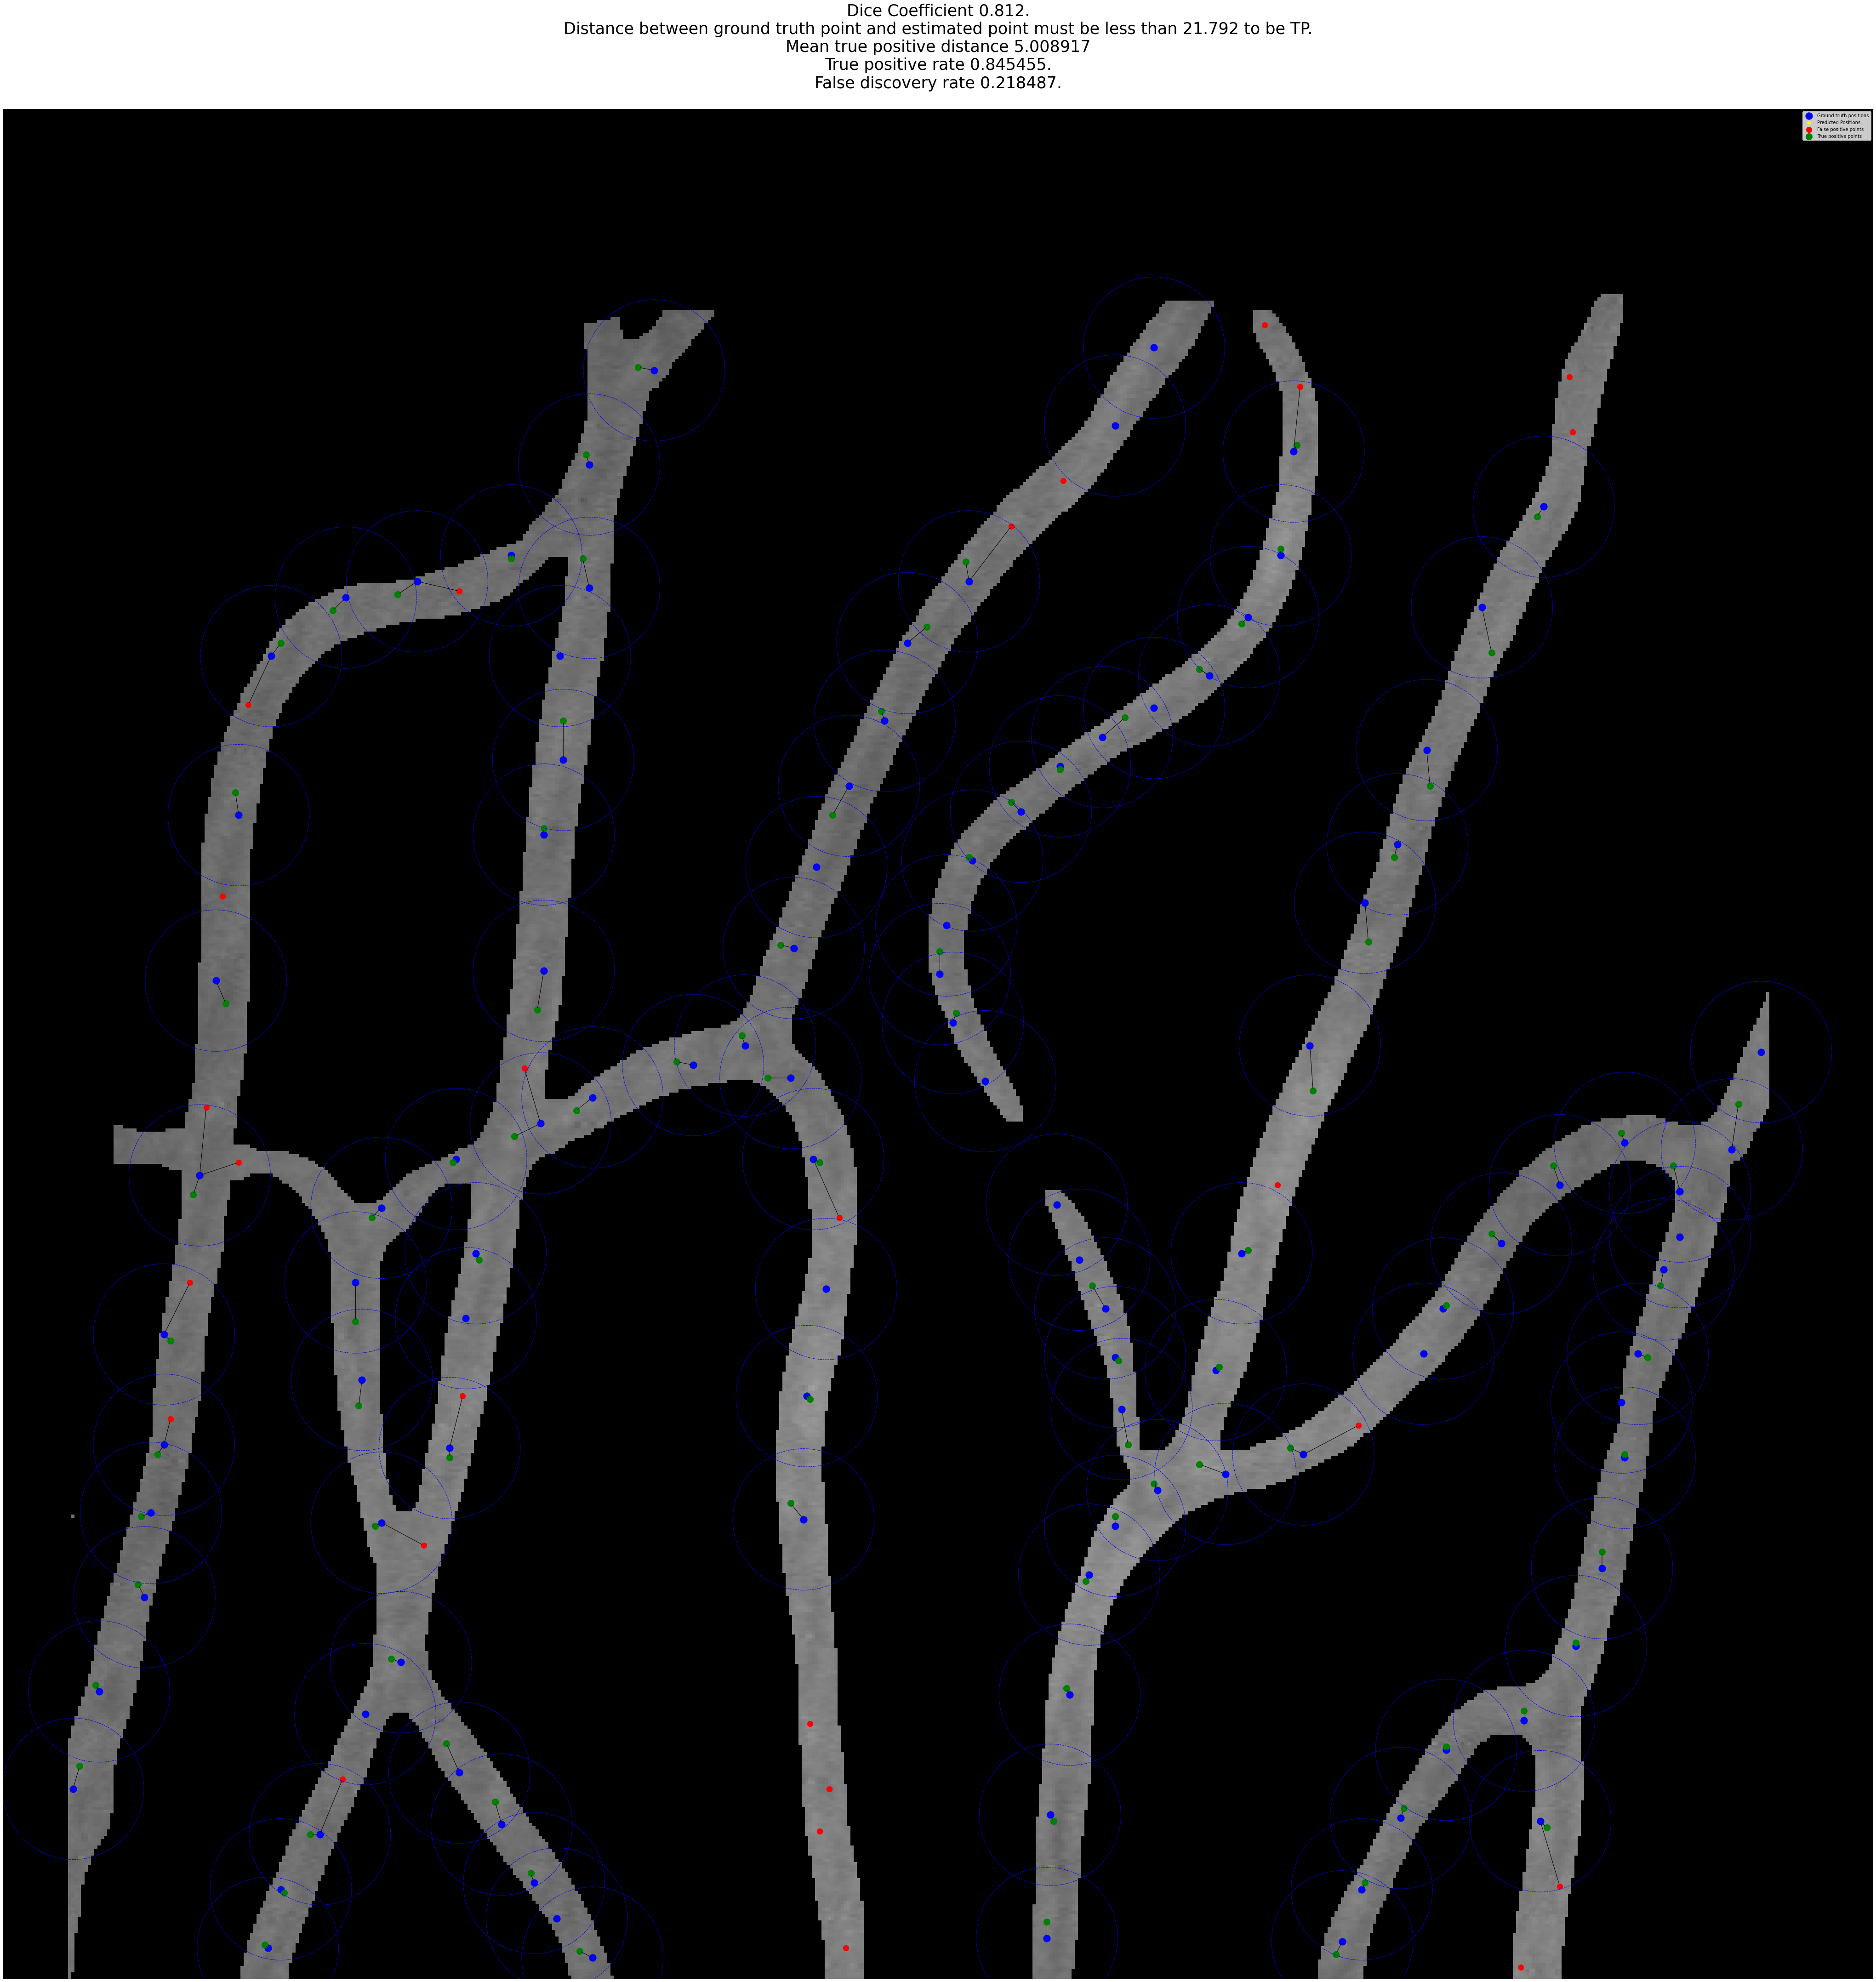

In [17]:
from plotutils import savefig_tight
plt.rcParams['axes.titlesize'] = 35
loaded_session_classifiers[vsc_idx].result_evaluations[best_prob_map_frame_idx].visualize()
savefig_tight(f'{os.path.splitext((loaded_session_classifiers[vsc_idx].session.basename))[0]}_result_evaluation.png')

### Worst probability map

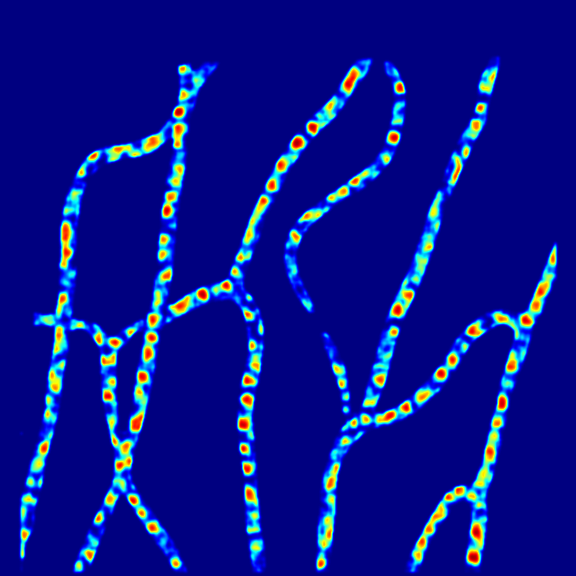

In [18]:
vsc_idx = 1
worse_dice_idx = np.argmin([vsc.dice for vsc in loaded_session_classifiers[vsc_idx].result_evaluations.values()])
worst_prob_map_frame_idx = list(loaded_session_classifiers[vsc_idx].result_evaluations.keys())[worse_dice_idx]

probability_map_cmap(loaded_session_classifiers[vsc_idx].probability_maps[worst_prob_map_frame_idx], 
                     loaded_session_classifiers[vsc_idx].result_evaluations[worst_prob_map_frame_idx].sigma)

### Best probability map

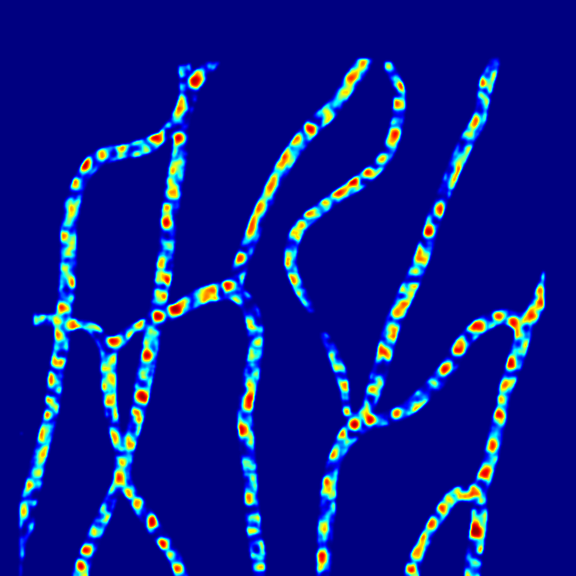

In [19]:
vsc_idx = 1
best_dice_idx = np.argmax([vsc.dice for vsc in loaded_session_classifiers[vsc_idx].result_evaluations.values()])
best_prob_map_frame_idx =list(loaded_session_classifiers[vsc_idx].result_evaluations.keys())[best_dice_idx]
prob_map = probability_map_cmap(loaded_session_classifiers[vsc_idx].probability_maps[best_prob_map_frame_idx], 
                     loaded_session_classifiers[vsc_idx].result_evaluations[best_prob_map_frame_idx].sigma)
prob_map

### Worst probability map

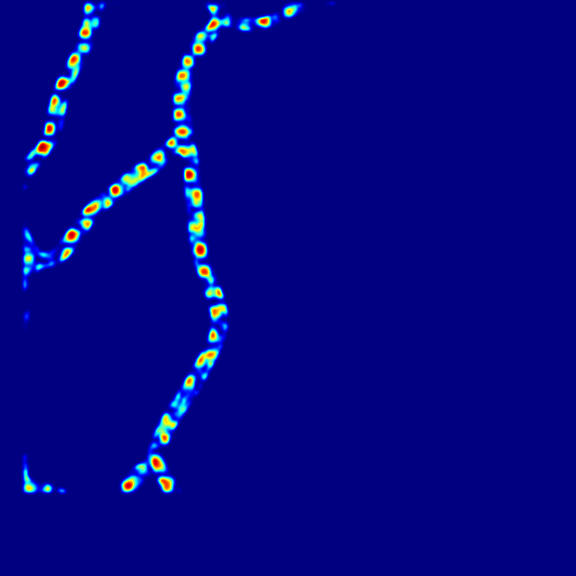

In [20]:
vsc_idx = 2
worse_dice_idx = np.argmin([vsc.dice for vsc in loaded_session_classifiers[vsc_idx].result_evaluations.values()])
worst_prob_map_frame_idx = list(loaded_session_classifiers[vsc_idx].result_evaluations.keys())[worse_dice_idx]

probability_map_cmap(loaded_session_classifiers[vsc_idx].probability_maps[worst_prob_map_frame_idx], 
                     loaded_session_classifiers[vsc_idx].result_evaluations[worst_prob_map_frame_idx].sigma)

### Best probability map

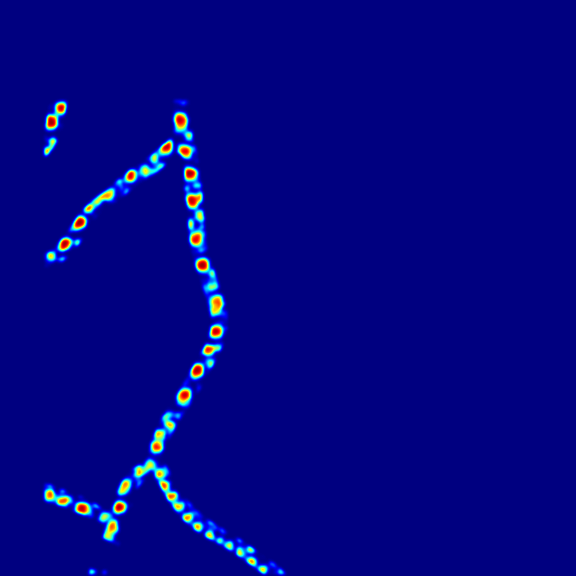

In [21]:
vsc_idx = 2
best_dice_idx = np.argmax([vsc.dice for vsc in loaded_session_classifiers[vsc_idx].result_evaluations.values()])
best_prob_map_frame_idx =list(loaded_session_classifiers[vsc_idx].result_evaluations.keys())[best_dice_idx]
probability_map_cmap(loaded_session_classifiers[vsc_idx].probability_maps[best_prob_map_frame_idx], 
                     loaded_session_classifiers[vsc_idx].result_evaluations[best_prob_map_frame_idx].sigma)